# Notebook 1: Survey Outcome Generation and Analysis
Includes replication code for:
- Table 1
- Figure S1
- Figure S2
- Figure S3
- Figure S4
- Table S1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skmisc.loess import loess
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

### Read Data

In [3]:
survey = pd.read_csv('data/raw_data/survey.csv')
phone_features = pd.read_csv('data/raw_data/phone_features.csv')
asset_cols = [col for col in survey.columns if 'asset' in col]

### Figure S1

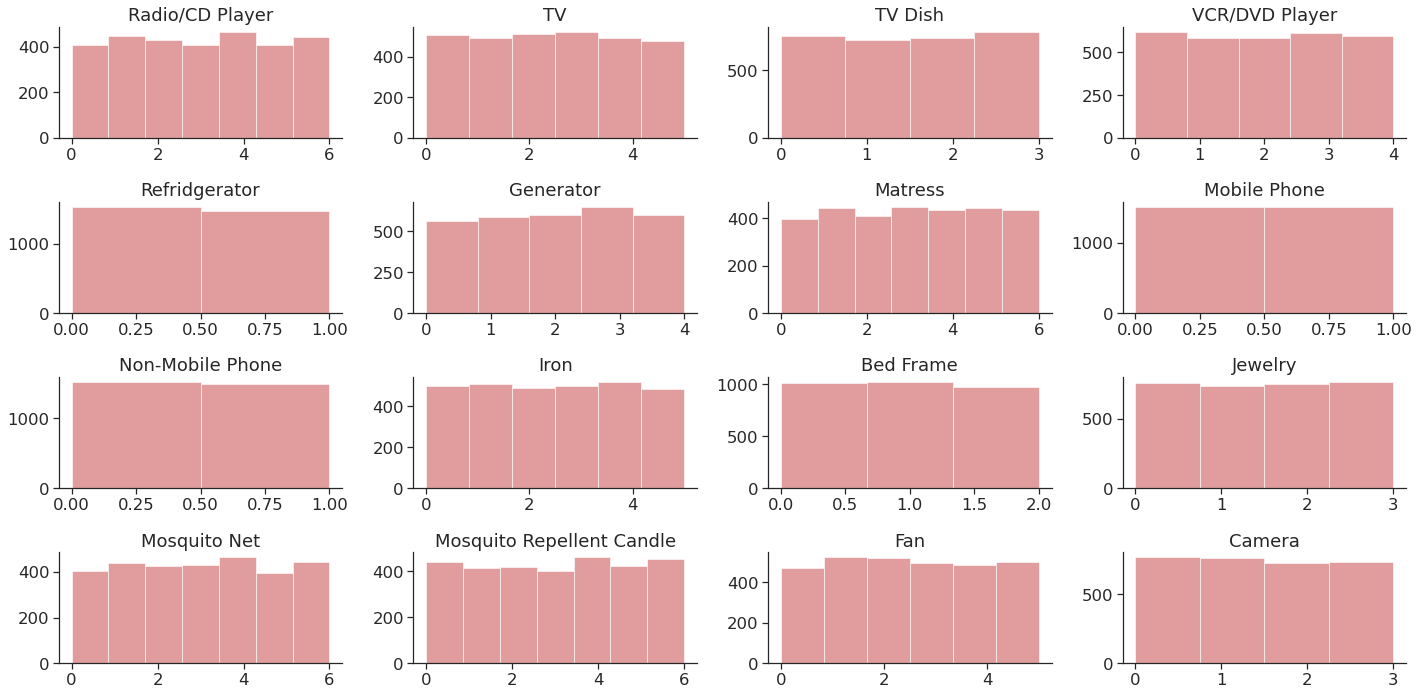

In [4]:
# Set up plot
sns.set(font_scale=1.5, style='white')
fig, ax = plt.subplots(4, 4, figsize=(20, 10))
ax = ax.flatten()
asset_names = ['Radio/CD Player', 'TV', 'TV Dish', 'VCR/DVD Player', 'Refridgerator', 'Generator', 'Matress',
              'Mobile Phone', 'Non-Mobile Phone', 'Iron', 'Bed Frame', 'Jewelry', 'Mosquito Net',
              'Mosquito Repellent Candle', 'Fan', 'Camera']

# Histograms
for f, feature in enumerate(asset_cols):
    ax[f].hist(survey[feature], color='indianred', alpha=0.6, bins=len(survey[feature].unique()))
    simpleaxis(ax[f])
    ax[f].set_title(asset_names[f])

# Clean up plot
plt.tight_layout()
plt.savefig('results/figures/figures1.png', dpi=500)
plt.show()

### Construct Asset Index and Poverty Line Outcome

In [5]:
# Scale to 0 mean and unit variance
scaler = StandardScaler()
standardized_assets = scaler.fit_transform(survey[asset_cols])

# Fit PCA
pca = PCA(n_components=1)
survey['asset_index'] = pca.fit_transform(standardized_assets).flatten()
print('Percent of variation explained by PCA: %.2f' % pca.explained_variance_ratio_)

Percent of variation explained by PCA: 0.07


In [6]:
# Calculate below poverty line
poverty_line = 5.1
survey['below_poverty_line'] = survey['log_expend'] < poverty_line
survey.to_csv('data/interim_analysis_datasets/survey_with_asset_index.csv', index=False)

### Table S1

In [7]:
tables1 = pd.DataFrame(asset_cols)
tables1.columns = ['Asset']
tables1['Magnitude'] = pca.components_[0]
tables1.to_csv('results/tables/tables1.csv')
tables1

,Asset,Magnitude
0,asset_radio_cd_player,0.567291
1,asset_tv,-0.453738
2,asset_tv_dish,0.215808
3,asset_vcr_dvd_player,0.105779
4,asset_refridgerator,-0.117560
5,asset_generator,0.119864
6,asset_matress,0.167480
7,asset_mobile_phone,0.012193
8,asset_non_mobile_phone,0.088616
9,asset_iron,-0.362772


### Matching survey and phone data

In [8]:
# Standard 1-1 matching
df = survey.merge(phone_features, on='phone_number', how='inner')
print('Number of survey observations matched to phone data at HH level: %i' % len(df))
df.to_csv('data/interim_analysis_datasets/merged_household.csv', index=False)

# 1-N matching
stack = survey.drop('phone_number', axis=1).copy().rename({'secondary_phone_number':'phone_number'}, axis=1)\
    .dropna(subset=['phone_number'])
survey_multi = pd.concat([survey.drop('secondary_phone_number', axis=1), stack])
df_multi = survey_multi.merge(phone_features, on='phone_number', how='inner')
print('Number of survey observations matched to phone data at individual level: %i' % len(df_multi))
df_multi.to_csv('data/interim_analysis_datasets/merged_individual.csv', index=False)

# Unmatched
unmatched = survey[~survey['phone_number'].isin(set(df['phone_number']))]
print('Number unmatched: %i' % len(unmatched))
print('Number unmatched with a phone: %i' % len(unmatched[unmatched['num_phones'] > 0]))
print('Number unmatched without a phone: %i' % len(unmatched[unmatched['num_phones'] == 0]))

Number of survey observations matched to phone data at HH level: 500
Number of survey observations matched to phone data at individual level: 537
Number unmatched: 2500
Number unmatched with a phone: 1848
Number unmatched without a phone: 652


### Table 1

In [9]:
# Variables for summary statistics
variables = ['ultra_poor', 'asset_index', 'log_expend', 'num_phones', 'fsec_index', 'fin_index', 'psych_index',
            'cwr_group']

# Calculations of summary statistics
full_sample = [survey[variable].mean() for variable in variables], \
    [survey[variable].std() for variable in variables]
matched_subsample = [df[variable].mean() for variable in variables], \
    [df[variable].std() for variable in variables]
unmatched_own_phone = [unmatched[unmatched['num_phones'] > 0][variable].mean() for variable in variables], \
    [unmatched[unmatched['num_phones'] > 0][variable].std() for variable in variables]
unmatched_no_phone = [unmatched[unmatched['num_phones'] == 0][variable].mean() for variable in variables], \
    [unmatched[unmatched['num_phones'] == 0][variable].std() for variable in variables]

# Table of summary statistics
table1 = pd.DataFrame(variables)
table1.columns = ['outcome']
table1['full_sample'] = ['%.2f (%.2f)' % (full_sample[0][i], full_sample[1][i]) for i in range(len(variables))]
table1['matched_subsample'] = ['%.2f (%.2f)' % (matched_subsample[0][i], matched_subsample[1][i]) 
                         for i in range(len(variables))]
table1['unmatched_own_phone'] = ['%.2f (%.2f)' % (unmatched_own_phone[0][i], unmatched_own_phone[1][i]) 
                         for i in range(len(variables))]
table1['unmatched_no_phone'] = ['%.2f (%.2f)' % (unmatched_no_phone[0][i], unmatched_no_phone[1][i]) 
                         for i in range(len(variables))]

# Save table
table1.to_csv('results/tables/table1.csv', index=False)
table1

,outcome,full_sample,matched_subsample,unmatched_own_phone,unmatched_no_phone
0,ultra_poor,0.24 (0.42),0.22 (0.42),0.24 (0.43),0.22 (0.42)
1,asset_index,-0.00 (1.04),0.08 (1.03),-0.01 (1.04),-0.04 (1.06)
2,log_expend,5.00 (0.99),5.03 (1.04),4.98 (0.98),5.04 (0.99)
3,num_phones,1.47 (1.11),1.52 (1.13),1.98 (0.80),0.00 (0.00)
4,fsec_index,-0.01 (1.01),0.03 (0.98),-0.04 (1.01),0.04 (1.01)
5,fin_index,0.00 (0.98),0.07 (0.99),-0.00 (0.98),-0.03 (0.98)
6,psych_index,0.03 (0.99),0.05 (0.98),0.01 (1.01),0.04 (0.96)
7,cwr_group,3.00 (1.42),3.09 (1.40),3.02 (1.41),2.90 (1.45)


In [10]:
# Correlations
correlations = pd.DataFrame(['Ultra-poor <-> Asset Index', 'Ultra-poor <-> Consumption',
                             'Asset Index <-> Consumption'])
correlations.columns = ['Correlation']
for data, label in [(survey, 'full_sample'), (df, 'matched_subsample'), 
                    (unmatched[unmatched['num_phones'] > 0], 'unmatched_own_phone'), 
                    (unmatched[unmatched['num_phones'] == 0], 'unmatched_no_phone')]:
    column = [np.corrcoef(data['ultra_poor'], data['asset_index'])[0][1]]
    column.append(np.corrcoef(data['ultra_poor'], data['log_expend'])[0][1])
    column.append(np.corrcoef(data['asset_index'], data['log_expend'])[0][1])
    correlations[label] = column
correlations.to_csv('results/tables/table1_correlations.csv', index=False)
correlations

,Correlation,full_sample,matched_subsample,unmatched_own_phone,unmatched_no_phone
0,Ultra-poor <-> Asset Index,0.013137,-0.002906,0.020321,0.005206
1,Ultra-poor <-> Consumption,-0.004710,-0.005216,0.010687,-0.045750
2,Asset Index <-> Consumption,-0.035136,-0.105992,-0.043412,0.041672


### Figure S2

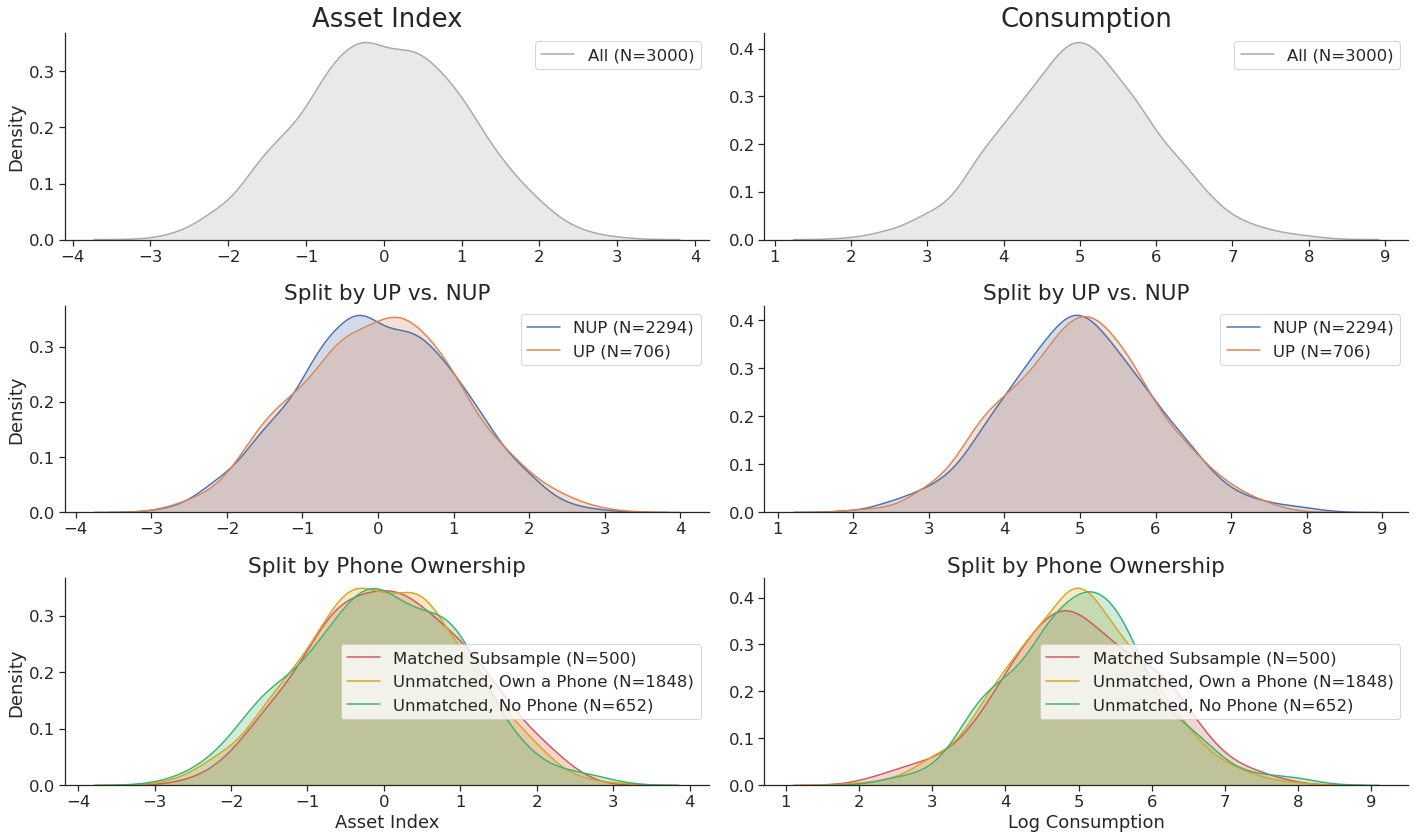

In [11]:
# Set up figure
sns.set(font_scale=1.5, style='white')
fig, ax = plt.subplots(3, 2, figsize=(20, 12))

# No split
sns.kdeplot(survey['asset_index'], color='darkgrey', ax=ax[0, 0], shade=True, label='All (N=%i)' % len(survey))
sns.kdeplot(survey['log_expend'], color='darkgrey', ax=ax[0, 1], shade=True, label='All (N=%i)' % len(survey))
ax[0, 0].set_title('Asset Index', fontsize='x-large')
ax[0, 1].set_title('Consumption', fontsize='x-large')

# Split by UP vs. NUP
sns.kdeplot(survey[survey['ultra_poor'] == 0]['asset_index'], ax=ax[1, 0], shade=True, 
            label='NUP (N=%i)' % len(survey[survey['ultra_poor'] == 0]))
sns.kdeplot(survey[survey['ultra_poor'] == 1]['asset_index'], ax=ax[1, 0], shade=True, 
            label='UP (N=%i)' % len(survey[survey['ultra_poor'] == 1]))
sns.kdeplot(survey[survey['ultra_poor'] == 0]['log_expend'], ax=ax[1, 1], shade=True, 
            label='NUP (N=%i)' % len(survey[survey['ultra_poor'] == 0]))
sns.kdeplot(survey[survey['ultra_poor'] == 1]['log_expend'], ax=ax[1, 1], shade=True, 
            label='UP (N=%i)' % len(survey[survey['ultra_poor'] == 1]))
ax[1, 0].set_title('Split by UP vs. NUP', fontsize='large')
ax[1, 1].set_title('Split by UP vs. NUP', fontsize='large')

# Split by phone ownership
sns.kdeplot(df['asset_index'], ax=ax[2, 0], shade=True, color='indianred', 
            label='Matched Subsample (N=%i)' % len(df))
sns.kdeplot(unmatched[unmatched['num_phones'] > 0]['asset_index'], ax=ax[2, 0], shade=True, color='goldenrod', 
            label='Unmatched, Own a Phone (N=%i)' % len(unmatched[unmatched['num_phones'] > 0]))
sns.kdeplot(unmatched[unmatched['num_phones'] == 0]['asset_index'], ax=ax[2, 0], shade=True, 
            color='mediumseagreen', 
            label='Unmatched, No Phone (N=%i)' % len(unmatched[unmatched['num_phones'] == 0]))
sns.kdeplot(df['log_expend'], ax=ax[2, 1], shade=True, color='indianred', 
            label='Matched Subsample (N=%i)' % len(df))
sns.kdeplot(unmatched[unmatched['num_phones'] > 0]['log_expend'], ax=ax[2, 1], shade=True, color='goldenrod', 
            label='Unmatched, Own a Phone (N=%i)' % len(unmatched[unmatched['num_phones'] > 0]))
sns.kdeplot(unmatched[unmatched['num_phones'] == 0]['log_expend'], ax=ax[2, 1], shade=True, 
            color='mediumseagreen', 
            label='Unmatched, No Phone (N=%i)' % len(unmatched[unmatched['num_phones'] == 0]))
ax[2, 0].set_title('Split by Phone Ownership', fontsize='large')
ax[2, 1].set_title('Split by Phone Ownership', fontsize='large')

# Clean figure
for a in ax.flatten():
    simpleaxis(a)
for i in range(ax.shape[0]):
    ax[i, 0].set_ylabel('Density')
ax[2, 0].set_xlabel('Asset Index')
ax[2, 1].set_xlabel('Log Consumption')
plt.tight_layout()
plt.savefig('results/figures/figures2.png', dpi=500)
plt.show()

### Figure S3

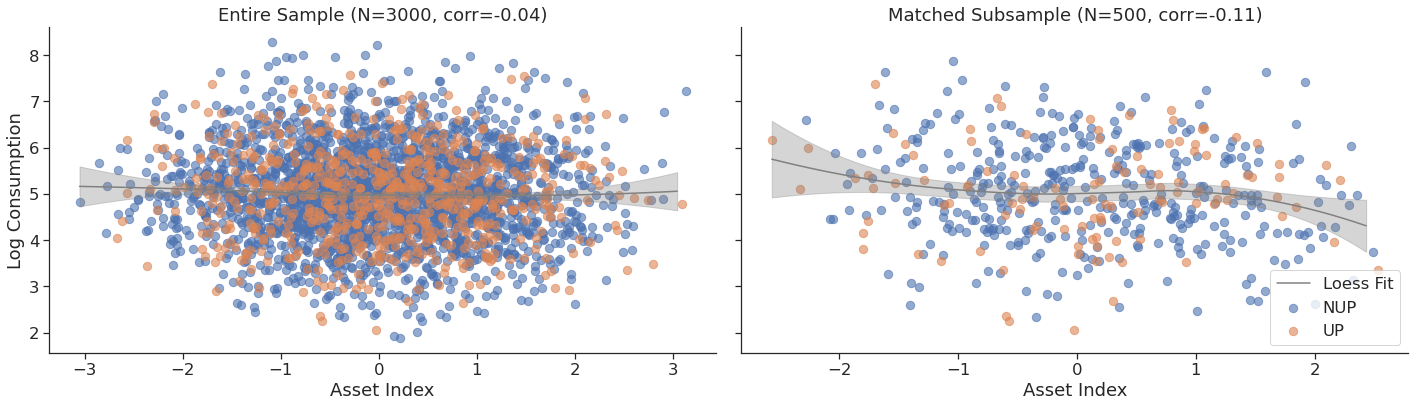

In [12]:
# Set up figure
sns.set(font_scale=1.5, style='white')
fig, ax = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Left scatterplot
ax[0].scatter(survey[survey['ultra_poor'] == 0]['asset_index'], survey[survey['ultra_poor'] == 0]['log_expend'],
             label='NUP', s=70, alpha=0.6)
ax[0].scatter(survey[survey['ultra_poor'] == 1]['asset_index'], survey[survey['ultra_poor'] == 1]['log_expend'],
             label='UP', s=70, alpha=0.6)
ax[0].set_title('Entire Sample (N=%i, corr=%.2f)' % 
                (len(survey), np.corrcoef(survey['asset_index'], survey['log_expend'])[0][1]))

# Right scatterplot
ax[1].scatter(df[df['ultra_poor'] == 0]['asset_index'], df[df['ultra_poor'] == 0]['log_expend'], label='NUP',
             s=70, alpha=0.6)
ax[1].scatter(df[df['ultra_poor'] == 1]['asset_index'], df[df['ultra_poor'] == 1]['log_expend'], label='UP',
             s=70, alpha=0.6)
ax[1].set_title('Matched Subsample (N=%i, corr=%.2f)' % 
                (len(df), np.corrcoef(df['asset_index'], df['log_expend'])[0][1]))

# LOESS fits
for s, sample in enumerate([survey, df]):
    assetindex_grid = np.arange(sample['asset_index'].min(), sample['asset_index'].max(), .1)
    l = loess(sample['asset_index'], sample['log_expend'])
    l.fit()
    pred = l.predict(assetindex_grid, stderror=True)
    lowess = pred.values
    ll = pred.confidence().lower
    ul = pred.confidence().upper
    ax[s].plot(assetindex_grid, lowess, color='grey', label='Loess Fit')
    ax[s].fill_between(assetindex_grid, ll, ul, alpha=.33, color='grey')

# Clean figure
for a in ax:
    simpleaxis(a)
    a.set_xlabel('Asset Index')
ax[1].legend(loc='lower right')
ax[0].set_ylabel('Log Consumption')
plt.tight_layout()
plt.savefig('results/figures/figures3.png', dpi=500)
plt.show()

### Figure S4

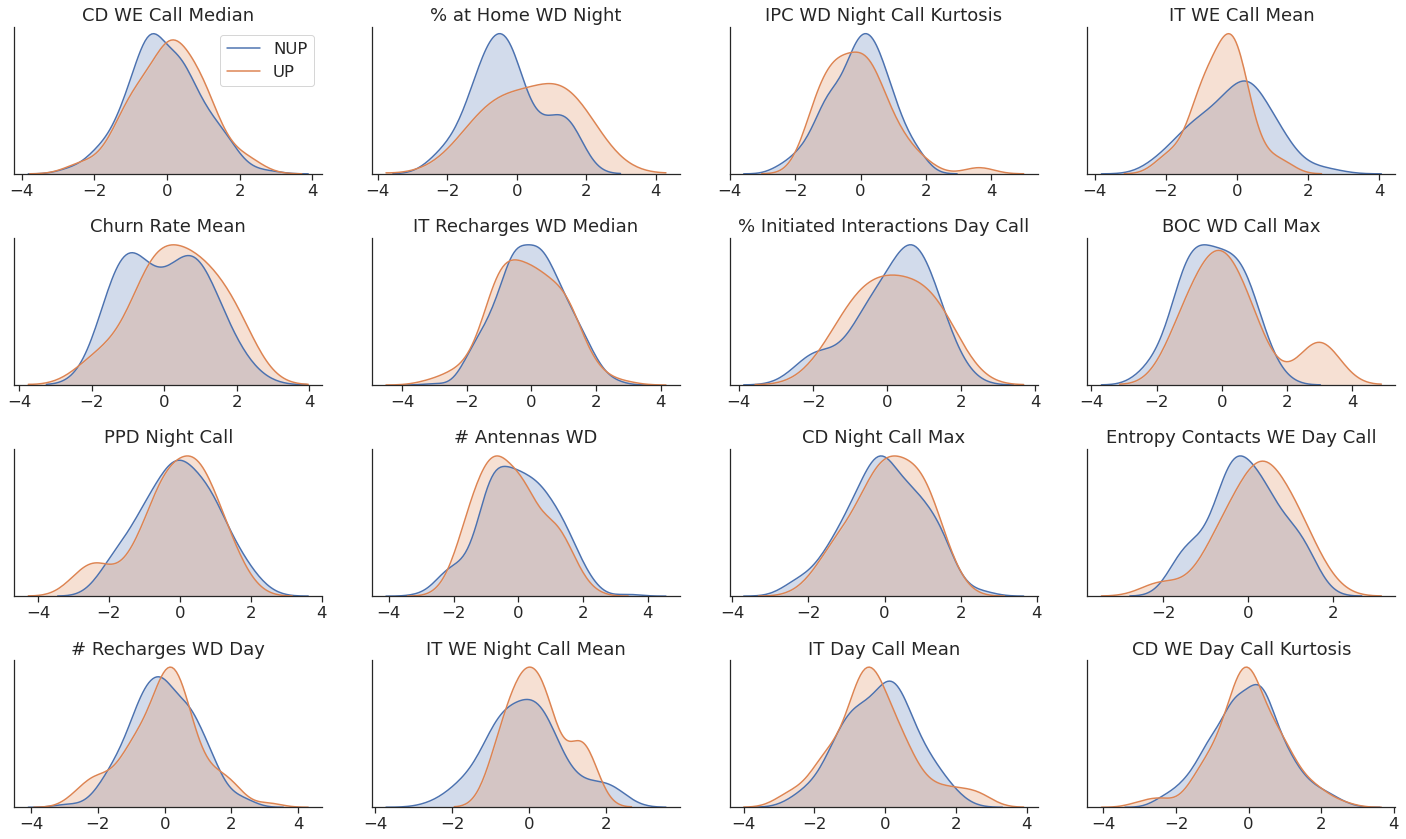

In [13]:
# Choose features
feats = ['call_duration__weekend__allday__call__median', 'percent_at_home__weekday__night', 
        'interactions_per_contact__weekday__night__call__kurtosis', 
        'interevent_time__weekend__allday__call__mean', 'churn_rate__mean', 
        'interevent_time_recharges__weekday__allday__median', 
        'percent_initiated_interactions__allweek__day__call', 'balance_of_contacts__weekday__allday__call__max',
        'percent_pareto_durations__allweek__night__call', 'number_of_antennas__weekday__allday',
        'call_duration__allweek__night__call__max', 'entropy_of_contacts__weekend__day__call',
        'number_of_recharges__weekday__day', 'interevent_time__weekend__night__call__mean',
        'interevent_time__allweek__day__call__mean', 'call_duration__weekend__day__call__kurtosis']
feat_names = ['CD WE Call Median', '% at Home WD Night', 'IPC WD Night Call Kurtosis', 'IT WE Call Mean',
             'Churn Rate Mean', 'IT Recharges WD Median', '% Initiated Interactions Day Call', 
             'BOC WD Call Max', 'PPD Night Call', '# Antennas WD', 'CD Night Call Max', 
              'Entropy Contacts WE Day Call', '# Recharges WD Day', 'IT WE Night Call Mean', 'IT Day Call Mean',
             'CD WE Day Call Kurtosis']

# Set up figure
sns.set(font_scale=1.5, style='white')
fig, ax = plt.subplots(4, 4, figsize=(20, 12))
ax = ax.flatten()

for f, feat in enumerate(feats):
    sns.kdeplot(df[df['ultra_poor'] == 0][feat], ax=ax[f], shade=True, label='NUP')
    sns.kdeplot(df[df['ultra_poor'] == 1][feat], ax=ax[f], shade=True, label='UP')
    ax[f].set_title(feat_names[f])
    
# Clean up plot
for a in ax:
    a.get_legend().remove()
    simpleaxis(a)
    a.axes.get_yaxis().set_ticks([])
ax[0].legend(loc='best')
plt.tight_layout()
plt.savefig('results/figures/figures4.png', dpi=500)
plt.show()